In [ ]:
# 1. Initialize Client and Load Data

import pandas as pd
import numpy as np
from agentds import BenchmarkClient

# 🔑 REPLACE WITH YOUR CREDENTIALS
client = BenchmarkClient(
    api_key="your-api-key-here",        # Get from your team dashboard
    team_name="your-team-name-here"     # Your exact team name
)

print("📂 Loading Commerce Challenge 1 data...")

# Load training and test data
train_sales = pd.read_csv("../datasets/sales_history_train.csv")
test_sales = pd.read_csv("../datasets/sales_history_test.csv")

print(f"✅ Data loaded:")
print(f"   Train sales: {train_sales.shape}")
print(f"   Test sales: {test_sales.shape}")
print(f"   Features: {list(train_sales.columns)}")

📂 Loading Commerce Challenge 1 data...
✅ Data loaded:
   Train sales: (66000, 5)
   Test sales: (12000, 4)
   Features: ['sku_id', 'week', 'units_sold', 'price', 'promo_flag']


In [273]:
events = pd.read_csv("../datasets/store_events.csv")
products = pd.read_csv("../datasets/products.csv")

In [274]:
train = train_sales.merge(events, on=["week"], how="left")
test = test_sales.merge(events, on=["week"], how="left")
train = train.merge(products, on=["sku_id"], how="left")
test = test.merge(products, on=["sku_id"], how="left")

In [275]:
train["week_sin"] = np.sin(2 * np.pi * train["week"] / 52)
train["week_cos"] = np.cos(2 * np.pi * train["week"] / 52)

test['week_sin'] = np.sin(2 * np.pi * test['week'] / 52)
test['week_cos'] = np.cos(2 * np.pi * test['week'] / 52)

In [276]:
sku_stats = train.groupby('sku_id')['units_sold'].agg(['mean']).reset_index()
sku_stats.rename(columns={'mean': 'sku_mean_sales'}, inplace=True)

train = train.merge(sku_stats, on='sku_id', how='left')
train['units_sold_norm'] = train['units_sold'] / train['sku_mean_sales']

In [277]:
test = test.merge(sku_stats, on='sku_id', how='left')

In [284]:
target = "units_sold_norm"
features = [col for col in train.columns if col not in [target, "week", "event_description", "category", "subtype", "sku_id", "price", "units_sold"]]

In [286]:
train_weeks = train["week"].unique()
train_cutoff = np.percentile(train_weeks, 80)

train_data = train[train["week"] <= train_cutoff]
valid_data = train[train["week"] > train_cutoff]

In [180]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [287]:
X_train = train[features]
y_train = train[target].values
X_test = test[features]

In [288]:
model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    train_data[features],
    train_data[target],
    eval_set=[(valid_data[features], valid_data[target])],
    eval_metric="rmse"
)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [167]:
final_model = lgb.LGBMRegressor(
    n_estimators=4000,
    learning_rate=0.01,
    num_leaves=8,
    max_depth=3,
    min_data_in_leaf=60,
    feature_fraction=0.9,
    bagging_fraction=0.9,
    lambda_l2=0.5,
    verbose=-1,
    random_state=42
)

final_model.fit(X_train, y_train, eval_metric="rmse")

,boosting_type,'gbdt'
,num_leaves,8
,max_depth,3
,learning_rate,0.01
,n_estimators,4000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


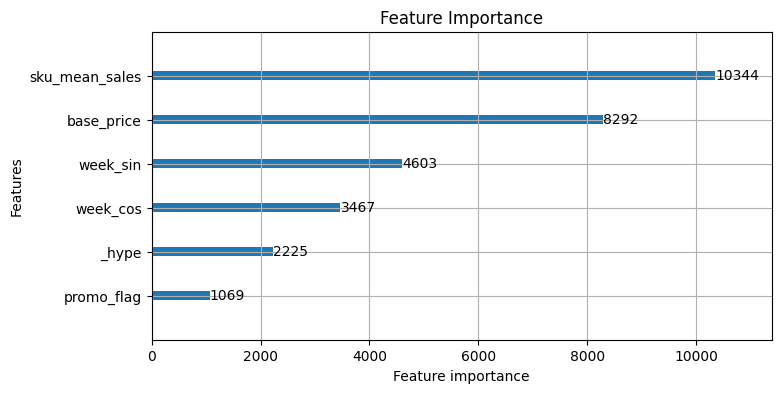

In [289]:
import matplotlib.pyplot as plt
lgb.plot_importance(model, figsize=(8, 4))
plt.title("Feature Importance")
plt.show()


In [290]:
preds_valid = model.predict(valid_data[features])
rmse = mean_squared_error(valid_data[target], preds_valid)
print("Validation RMSE:", rmse)

Validation RMSE: 0.15077690022151077


In [291]:
model.fit(
    train[features],
    train[target],
    eval_metric="rmse"
)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [292]:
predictions = model.predict(X_test)

In [293]:
predictions = predictions * test['sku_mean_sales']

In [294]:
submission_df = pd.DataFrame({
    'sku_id': test_sales['sku_id'],
    'week': test_sales['week'], 
    'units_sold_next_week': predictions
})

# Save predictions
submission_df.to_csv("commerce_challenge1_predictions.csv", index=False)
print(f"✅ Predictions saved: {submission_df.shape[0]} predictions")
print(f"   Preview: {submission_df.head(3)}")
print(f"   Prediction range: {predictions.min():.2f} to {predictions.max():.2f}")

✅ Predictions saved: 12000 predictions
   Preview:    sku_id  week  units_sold_next_week
0       1    45             44.512850
1       1    46             44.787301
2       1    47             45.075438
   Prediction range: 2.81 to 208.10


In [295]:
# 3. Submit Predictions

# Submit predictions to the competition
print("🚀 Submitting predictions...")

try:
    result = client.submit_prediction("Commerce", 1, "commerce_challenge1_predictions.csv")
    
    if result['success']:
        print("✅ Submission successful!")
        print(f"   📊 Score: {result['score']:.4f}")
        print(f"   📏 Metric: {result['metric_name']}")
        print(f"   ✔️  Validation: {'Passed' if result['validation_passed'] else 'Failed'}")
    else:
        print("❌ Submission failed!")
        print(f"   Error details: {result.get('details', {}).get('validation_errors', 'Unknown error')}")
        
except Exception as e:
    print(f"💥 Submission error: {e}")
    print("🔧 Check your API key and team name are correct!")

print("\n🎯 Next steps:")
print("   1. Try incorporating relevant information outside this table!")
print("   2. Move on to Commerce Challenge 2!")

🚀 Submitting predictions...
✅ Prediction submitted successfully!
📊 Score: 4.5314 (RMSE)
✅ Validation passed
✅ Submission successful!
   📊 Score: 4.5314
   📏 Metric: RMSE
   ✔️  Validation: Passed

🎯 Next steps:
   1. Try incorporating relevant information outside this table!
   2. Move on to Commerce Challenge 2!
